# Figure 6
---

This notebook generate a purpose specific figure that includes examples of GrIMP image data for Zacharie Isstrom, NE Greenland. 

It is not meant to be tutorial in nature. Tutorials for the packages used to create the plots can be found [here](https://github.com/fastice/GrIMPTools).

In [1]:
#%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import grimpfunc as grimp
import nisardev as nisar
import panel as pn
pn.extension()
from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import matplotlib.pyplot as plt
import numpy as np
import dask
from shapely.geometry import Polygon
import geopandas as gpd
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)
import matplotlib.gridspec as gridspec

## Login to EarthData/NSIDC

Unless the data have already been downloaded, users will need to sign in to NSIDC/EarthData to run the rest of the notebook. If a ~/.netrc exists, it will load credentials from there. If not, it will create or append to one after the login has been processed since it is needed by GDAL (see [NSIDCLoginNotebook](https://github.com/fastice/GRiMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb)) for more details on security issues.

In [2]:
# Set path for gdal 
env = dict(GDAL_HTTP_COOKIEFILE = os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR = os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)
# Get login
myLogin = grimp.NASALogin()  # If login appears not to work, try rerunning this cell
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.


## Bounding Box

The examples in this glacier will focus on Zacharie Isstrom in northern Greenland, which can be defined with the following bounding box.

In [3]:
bbox = {'minx': 440000, 'miny': -1140000, 'maxx': 525000, 'maxy': -1080000}
xbox = np.array([bbox[x] for x in ['minx', 'minx', 'maxx', 'maxx', 'minx']]) * 0.001
ybox = np.array([bbox[y] for y in ['miny', 'maxy', 'maxy', 'miny', 'miny']]) * 0.001

## Search for Data

Greenland Mapping Project data can be searched for using instances of the class, `cmrUrls`, which provides a simple graphical and non-graphical interface to the GMP products. In this example, the search tool is used with `mode=image`, which restricts the search to **NSIDC-0723** image products. The date range can restricted with `firstDate='YYYY-MM-DD'` and `lastDate='YYYY-MM-DD'`. The images are distributed as uncalibrated **image** products or calibrated **sigma0** ($\sigma_o$) and **gamma0** ($\gamma_o$) products, which can be specified as `productFilter='image'`. In the following example, these search will be carried out based on the input parameters, but a gui search window will popup, which allows the search parameters to be altered.

### Image Data

In [4]:
myImageUrls = grimp.cmrUrls(mode='image')  # mode image restricts search to the image products
myImageUrls.initialSearch(firstDate='2020-01-01', lastDate='2020-01-06', productFilter='image'); 

If the search parameters do not need to be altered, then insering a semicolon at the end of the line will supress the output. So the corresponding sigma0 and gamma0 products can searched for as:

In [5]:
mySigma0Urls = grimp.cmrUrls(mode='image')  # mode image restricts search to the image products
mySigma0Urls.initialSearch(firstDate='2020-01-01', lastDate='2020-02-24', productFilter='sigma0');
myGamma0Urls = grimp.cmrUrls(mode='image')  # mode image restricts search to the image products
myGamma0Urls.initialSearch(firstDate='2020-01-01', lastDate='2020-02-24', productFilter='gamma0');

## Loading the data

Now that the data have been located, they can be opened for access. The list of urls is given by `myImageUrls.getCogs()` to be passed into the `readSeriesFromTiff` method.

In [6]:
myImageSeries = nisar.nisarImageSeries()  # Instantiate the series object
myImageSeries.readSeriesFromTiff(myImageUrls.getCogs())  # Open images with lazy reads
myImageSeries.subset;  # Display map of data layout - add ; to suppress this output

At nearly 12GB, and this is only 1 of 300+ products, downloading this full data set would take a substantial amount of time, even over a fast network. But if we use the bounding box defined above, the data set can be limited to just the region of interest as follows:

In [7]:
myImageSeries.subSetImage(bbox)
myImageSeries.subset;

Here the volume as been greatly reduced. At this stage, the data are still on the NSIDC server. At this point several actions can be taken (e.g., displaying the data), which will automatically download the data using dask. While this implicit download is convenient, it can add time for multiple operations on the data. While in principle the data are cached by the OS, they can be flushed from the cache, require re-download. The volume in this example is not large for most computers, so it makse sense to explicily download the data with as shown next:

In [8]:
myImageSeries.loadRemote()

[########################################] | 100% Completed | 25.5s


The process can now be repeated with the sigma0 and gamma0 products.

In [9]:
myGamma0Series = nisar.nisarImageSeries()  # Instantiate the series object
myGamma0Series.readSeriesFromTiff(myGamma0Urls.getCogs())  # Open images with lazy reads
myGamma0Series.subSetImage(bbox)  # Clip image area
myGamma0Series.loadRemote()  # Download clipped regions

[########################################] | 100% Completed |  1min 27.1s


In [10]:
mySigma0Series = nisar.nisarImageSeries()  # Instantiate the series object
mySigma0Series.readSeriesFromTiff(mySigma0Urls.getCogs())  # Open images with lazy reads
mySigma0Series.subSetImage(bbox)  # Clip image area
mySigma0Series.loadRemote()  # Download clipped regions

[########################################] | 100% Completed |  1min 35.4s


## Overview Images

The code above download a small subset, but in some cases its nice to have an overview of the full data set. As noted above, a nice feature of COGs is that they include image pyramids. A reduced resolution data set can be created as:

In [11]:
myOverviewSeries = nisar.nisarImageSeries()  # Instantiate the series object
myOverviewSeries.readSeriesFromTiff(myImageUrls.getCogs()[0:2],  overviewLevel=4)  # Open image 4->800 m res (2^(n+1) * original res) = 32*.25
myOverviewSeries.loadRemote()

[########################################] | 100% Completed | 10.2s


## Image Types

As noted above, the GMP Sentinel image mosaics are produced as **image** (byte scaled with colortable stretch to enhance contrast), **sigm0** (calibrated radar cross section), **gamma0** (calibrated cross section that reduces topographic effects). A greater description of the characteristics of these products is beyond the scope of this notebooks but can be found in the [user guide for NSIDC-0723](https://nsidc.org/data/nsidc-0723/). The following cell illustrates how each of these products can be displayed for a given date with the overview image used as an inset map. 

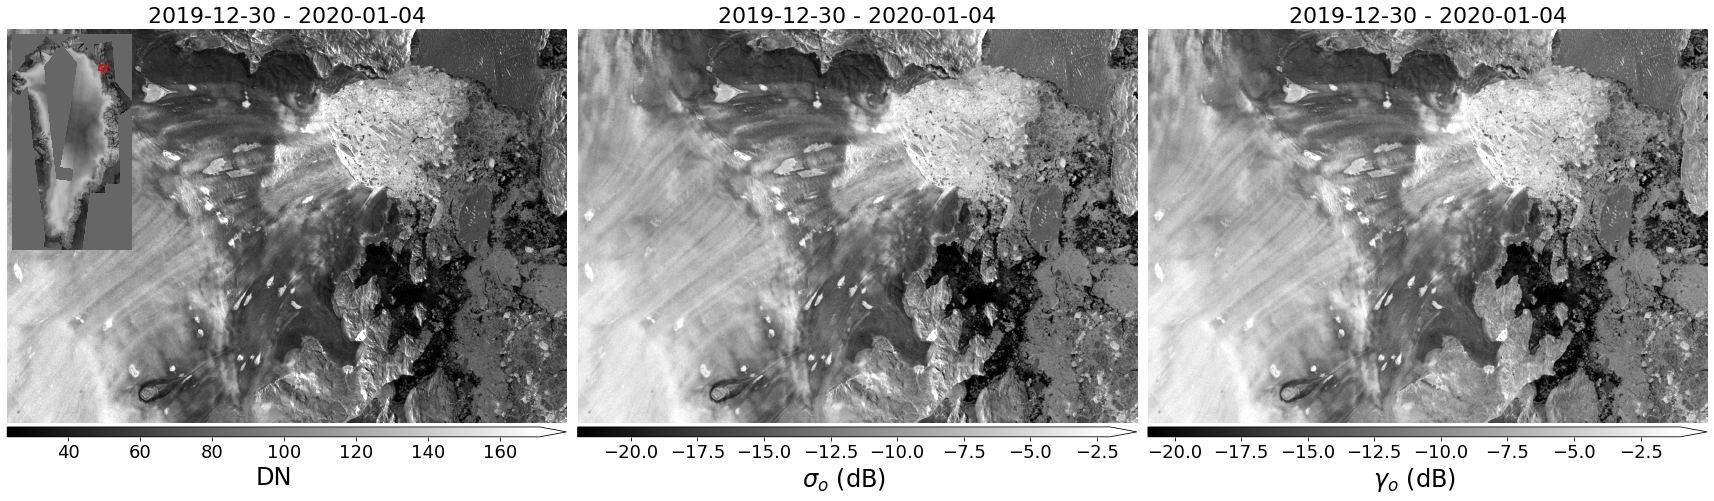

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(24, 11))
#
# Display each image type
for mySeries, ax in zip([myImageSeries, mySigma0Series, myGamma0Series], axes):
    mySeries.displayImageForDate(date='2020-01-01', midDate=False, ax=ax, percentile=99, 
                                 labelFontSize=24, plotFontSize=18, titleFontSize=22, 
                                 colorBarSize='2.5%', colorBarPosition='bottom')  # Clips to 1% (100-99) and 99 percentile
    ax.axis('off')
height = 3
fig.tight_layout()
#
# Add an inset map to the first panel
axInset = inset_axes(axes[0], width=height * myOverviewSeries.sx/myOverviewSeries.sy, height=height, loc=2)
myOverviewSeries.displayImageForDate(date='2020-01-01', ax=axInset, colorBar=False, axisOff=True, units='km', 
                                     masked=0, cmap=plt.cm.gray.with_extremes(bad=(.4,0.4,.4)), title='')
axInset.plot(xbox, ybox, 'r');
fig.savefig('Figure6.jpg', dpi=140, bbox_inches='tight')